In [3]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import os, json
import re
import glob
from tqdm import tqdm
import numpy as np

### RCT Calculation

In [32]:
'''
GET RCT VALUES
'''
exp_name ="async_ratio_results/as_dmix1_1.5_temp" ## CHANGE FOR EACH RUN
log_files = glob.glob(f"results/{exp_name}/*.csv")
df = pd.concat([pd.read_csv(log_file, names=['tid', 'this_nid', 'logged_time'], usecols=[0, 1, 2]) for log_file in log_files], ignore_index=True)

# Ensure 'logged_time' is treated as numeric for comparison
df['logged_time'] = pd.to_numeric(df['logged_time'], errors='coerce')

# Calculate max and min logged time for each tid
rct_results = []
grouped_df = df.groupby('tid')

for tid, group in tqdm(grouped_df, desc="Processing for RCT calc..."):
    max_time = group['logged_time'].max()
    start_time = group.loc[group['this_nid'] == 'mewbie_client', 'logged_time'].min()
    
    # Calculate RCT only if start_time is not NaN
    if pd.notna(start_time):
        rct = (max_time - start_time)/1000 # convert to ms
        rct_results.append(rct)

# Write rct_results as JSON
with open(f"results/{exp_name}_rct.json", "w") as f:
    json.dump(rct_results, f)

Processing for RCT calc...: 100%|██████████| 86502/86502 [00:35<00:00, 2402.90it/s]


### Throughput vs RCT Analysis

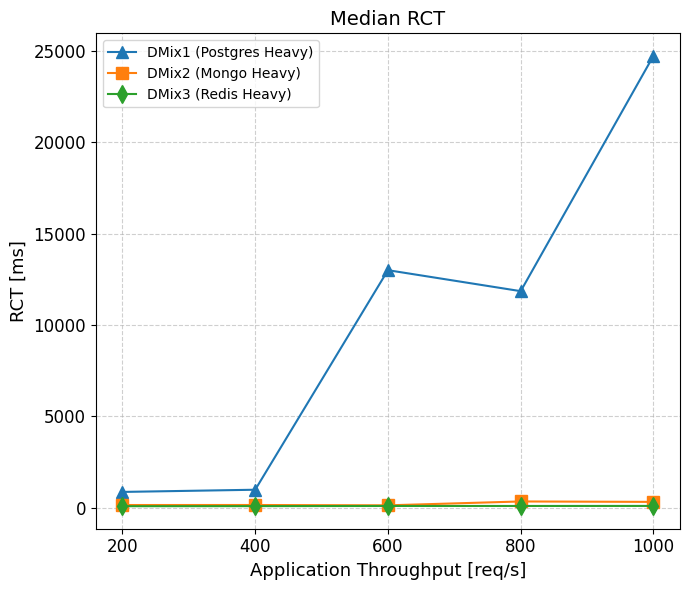

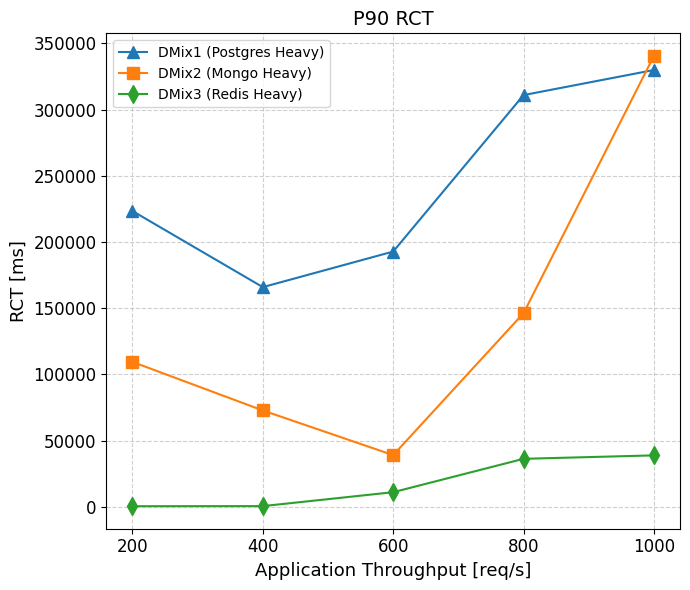

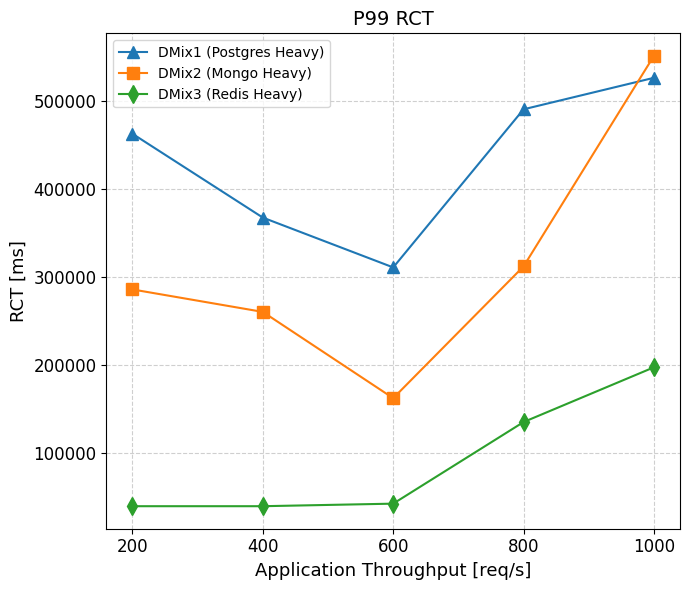

In [3]:
def read_rct_data(dir_name, exp_name):
    '''
    return: dict; key: exp_thr, value: list of rct results
    '''
    # eg: dir_name = 'pg_heavy_results', eg: file_name = 'pgh_thr100_rct.json'
    rct_results = {}
    for file in os.listdir(dir_name):
        if file.endswith('.json'):
            res = []
            match = re.search(r'thr(\d+)_', file)
            exp_thr = match.group(1) 
            with open(os.path.join(dir_name, file), 'r') as f:
                res = json.load(f)
            rct_results[exp_thr] = res
    return (exp_name, rct_results)

pg_rct_res = read_rct_data("./results/pg_heavy_results", "DMix1 (Postgres Heavy)")
mongo_rct_res = read_rct_data("./results/mongo_heavy_results", "DMix2 (Mongo Heavy)")
redis_rct_res = read_rct_data("./results/redis_heavy_results", "DMix3 (Redis Heavy)")
rct_vs_thr_exp_input = [pg_rct_res, mongo_rct_res, redis_rct_res]

def gen_percentile_values(rct_vs_thr_exp_input):
    exp_output = {} # key: exp (eg: pg_heavy), value: dict; key: median/p90/p99 value: {thr: rct value, ...}
    for exp, dets in rct_vs_thr_exp_input:
        exp_output[exp] = {}
        for thr, rct_vals in dets.items():
            # if exp not in exp_output:
            #     exp_output[exp] = {}
            exp_output[exp][thr] = {}
            rct_median = np.median(rct_vals)
            rct_p90 = np.percentile(rct_vals, 90)
            rct_p99 = np.percentile(rct_vals, 99)
            exp_output[exp][thr]['median'] = rct_median
            exp_output[exp][thr]['p90'] = rct_p90
            exp_output[exp][thr]['p99'] = rct_p99
    return exp_output

exp_output = gen_percentile_values(rct_vs_thr_exp_input)

def plot_percentile_throughput(data, title_suffix="RCT"):
    """
    Plot separate graphs for Median, P90, and P99 RCT values, with different markers for each workload.

    Parameters:
    - data (dict): Nested dictionary where each outer key is a workload (e.g., 'Postgres Heavy')
                   and the inner dictionary contains throughput values (keys) and metrics (values).
    - title_suffix (str): Suffix for the titles of the plots.
    """
    percentiles = ['median', 'p90', 'p99']  
    markers = ['^', 's', 'd', '*']  
    workloads = list(data.keys())  
    marker_map = {workload: markers[i % len(markers)] for i, workload in enumerate(workloads)}

    for percentile in percentiles:
        plt.figure(figsize=(7, 6))  

        for workload, values in data.items():
            x = sorted(values.keys(), key=lambda k: int(k))  
            y = [values[k][percentile] for k in x] 
            plt.plot(x, y, marker=marker_map[workload], markersize=9, label=workload)

        # Add labels and title
        plt.xlabel('Application Throughput [req/s]', fontsize=13)
        plt.xticks(fontsize=12)
        plt.ylabel('RCT [ms]', fontsize=13)
        plt.yscale('linear')
        plt.yticks(fontsize=12)
        plt.title(f'{percentile.capitalize()} {title_suffix}', fontsize=14)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)  
        plt.tight_layout()  
        plt.show()


plot_percentile_throughput(exp_output)

In [ ]:
def read_rct_data(dir_name, exp_name):
    '''
    return: dict; key: exp_thr, value: list of rct results
    '''
    # eg: dir_name = 'pg_heavy_results', eg: file_name = 'pgh_thr100_rct.json'
    rct_results = {}
    for file in os.listdir(dir_name):
        if file.endswith('.json'):
            res = []
            match = re.search(r'thr(\d+)_', file)
            exp_thr = match.group(1) 
            with open(os.path.join(dir_name, file), 'r') as f:
                res = json.load(f)
            rct_results[exp_thr] = res
    return (exp_name, rct_results)

pg_rct_res = read_rct_data("./results/pg_heavy_results", "DMix1 (Postgres Heavy)")
mongo_rct_res = read_rct_data("./results/mongo_heavy_results", "DMix2 (Mongo Heavy)")
redis_rct_res = read_rct_data("./results/redis_heavy_results", "DMix3 (Redis Heavy)")
rct_vs_thr_exp_input = [pg_rct_res, mongo_rct_res, redis_rct_res]

def gen_percentile_values(rct_vs_thr_exp_input):
    exp_output = {} # key: exp (eg: pg_heavy), value: dict; key: median/p90/p99 value: {thr: rct value, ...}
    for exp, dets in rct_vs_thr_exp_input:
        exp_output[exp] = {}
        for thr, rct_vals in dets.items():
            # if exp not in exp_output:
            #     exp_output[exp] = {}
            exp_output[exp][thr] = {}
            rct_median = np.median(rct_vals)
            rct_p90 = np.percentile(rct_vals, 90)
            rct_p99 = np.percentile(rct_vals, 99)
            exp_output[exp][thr]['median'] = rct_median
            exp_output[exp][thr]['p90'] = rct_p90
            exp_output[exp][thr]['p99'] = rct_p99
    return exp_output

exp_output = gen_percentile_values(rct_vs_thr_exp_input)

def plot_percentile_throughput(data, title_suffix="RCT"):
    """
    Plot separate graphs for Median, P90, and P99 RCT values, with different markers for each workload.

    Parameters:
    - data (dict): Nested dictionary where each outer key is a workload (e.g., 'Postgres Heavy')
                   and the inner dictionary contains throughput values (keys) and metrics (values).
    - title_suffix (str): Suffix for the titles of the plots.
    """
    percentiles = ['median', 'p90', 'p99']  
    markers = ['^', 's', 'd', '*']  
    workloads = list(data.keys())  
    marker_map = {workload: markers[i % len(markers)] for i, workload in enumerate(workloads)}

    for percentile in percentiles:
        plt.figure(figsize=(7, 6))  

        for workload, values in data.items():
            x = sorted(values.keys(), key=lambda k: int(k))  
            y = [values[k][percentile] for k in x] 
            plt.plot(x, y, marker=marker_map[workload], markersize=9, label=workload)

            # Add labels and title
            plt.xlabel('Application Throughput [req/s]', fontsize=13)
            plt.xticks(fontsize=12)
            plt.ylabel('RCT [ms]', fontsize=13)
            plt.yscale('linear')
            plt.ylim(0)
            plt.yticks(fontsize=12)
            plt.title(f'{percentile.capitalize()} {title_suffix}', fontsize=14)
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)  
            plt.tight_layout()  
            plt.show()
        


plot_percentile_throughput(exp_output)

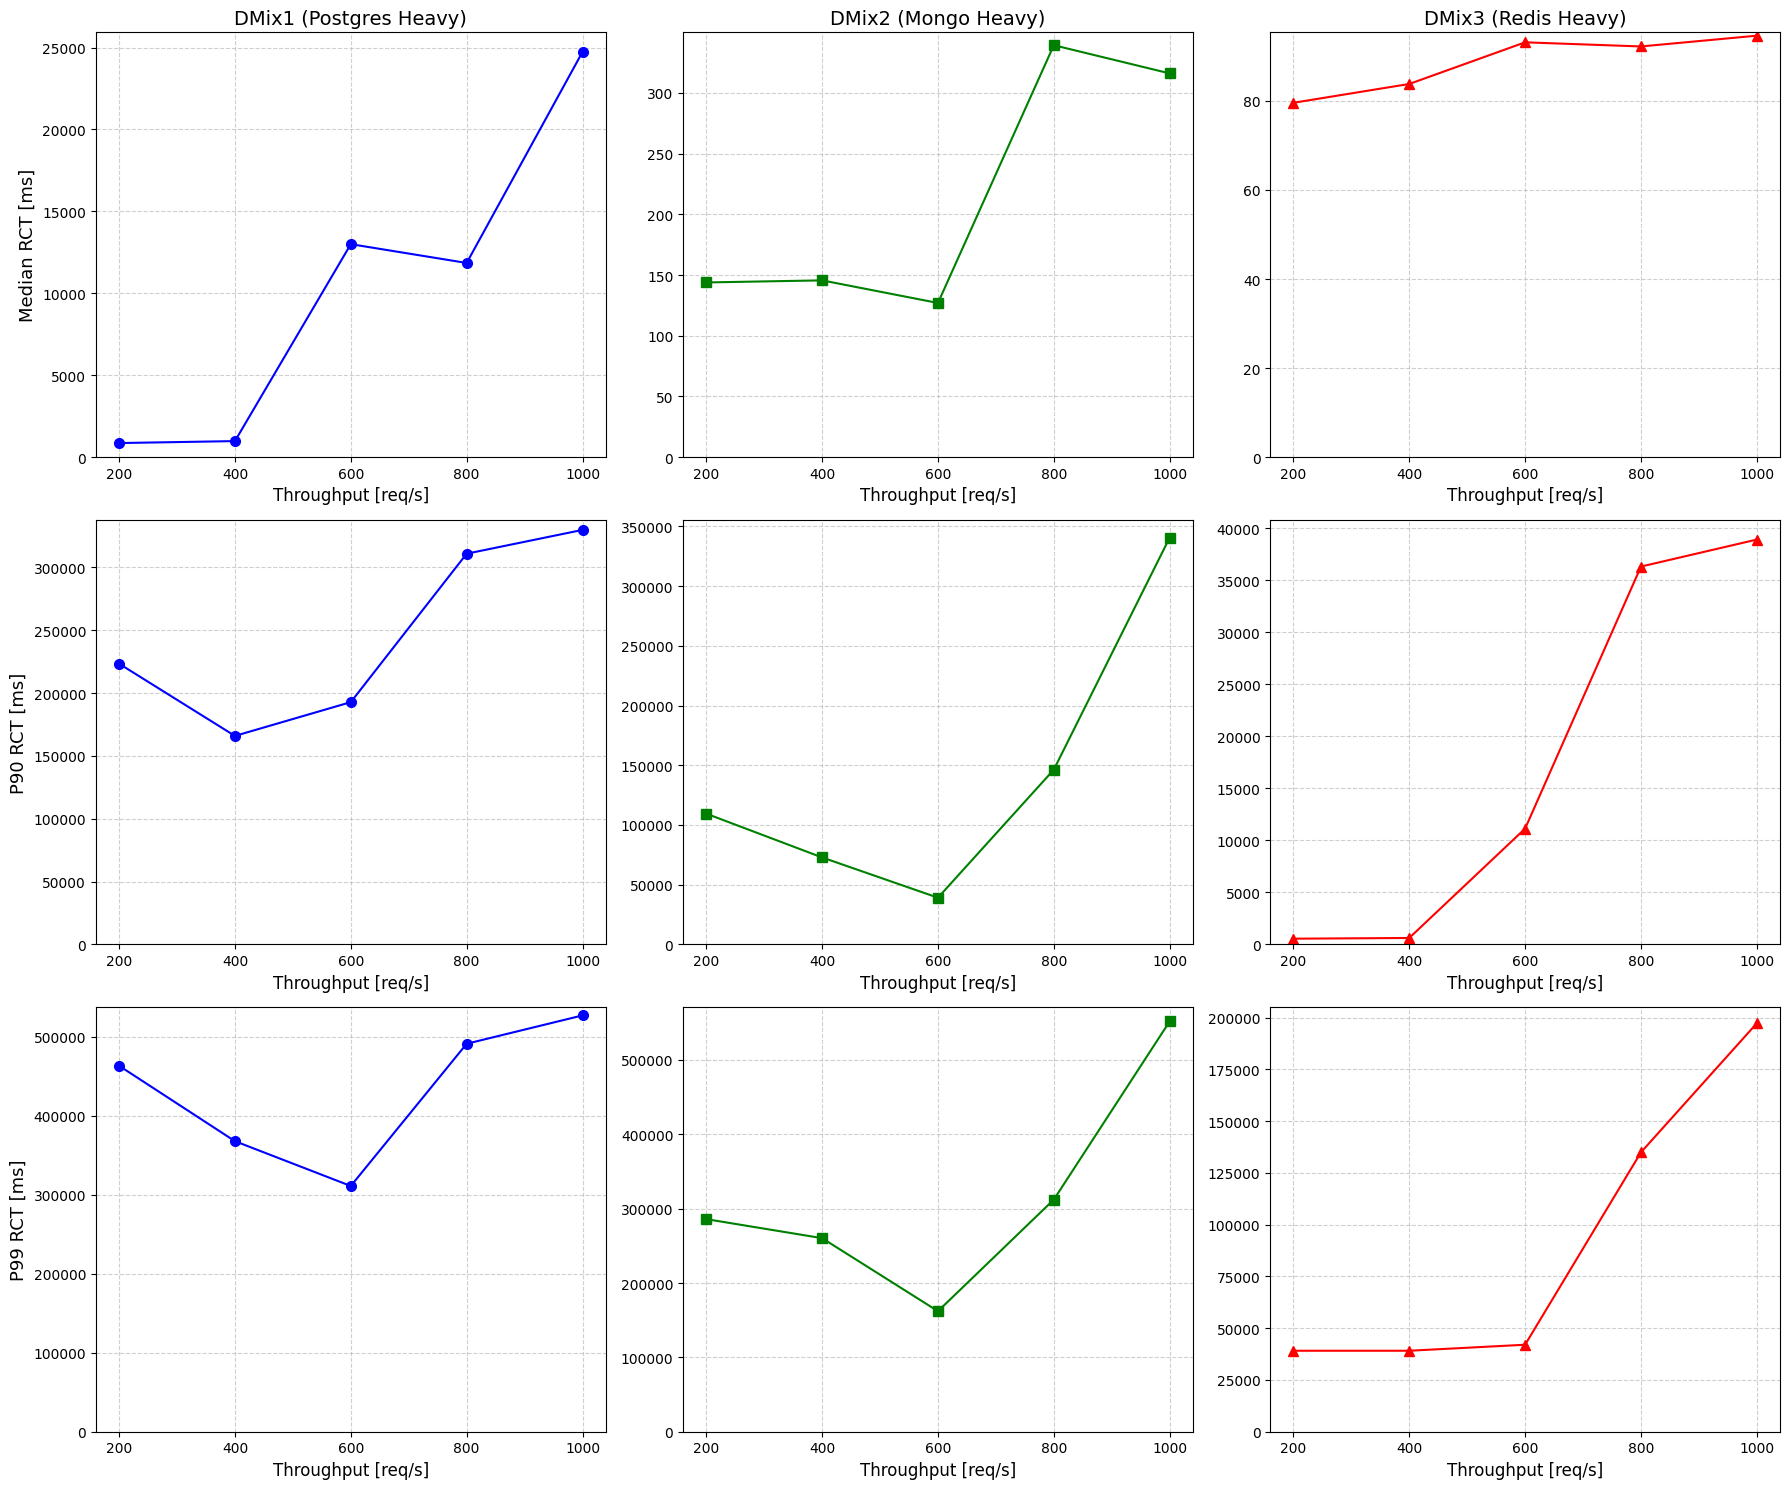

In [7]:
def plot_9_separate_subplots(data, title_suffix="RCT"):
    """
    Plot 9 separate subplots arranged in 3 rows and 3 columns:
    - Rows: Percentiles (Median, P90, P99)
    - Columns: Workloads (Postgres, Mongo, Redis)
    
    Parameters:
    - data (dict): Nested dictionary where each outer key is a workload (e.g., 'Postgres Heavy')
                   and the inner dictionary contains throughput values (keys) and metrics (values).
    - title_suffix (str): Suffix for the titles of the plots.
    """
    percentiles = ['median', 'p90', 'p99']  
    workloads = list(data.keys())  
    colors = ['b', 'g', 'r']  # Colors for lines
    markers = ['o', 's', '^']  # Markers for lines
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))  # 3 rows, 3 columns
    
    for row_idx, percentile in enumerate(percentiles):
        for col_idx, workload in enumerate(workloads):
            ax = axes[row_idx, col_idx]
            workload_data = data[workload]
            x = sorted(workload_data.keys(), key=lambda k: int(k))  # Sort throughput keys
            y = [workload_data[thr][percentile] for thr in x]  # Extract RCT values
            
            # Plot data
            ax.plot(
                x, y,
                color=colors[col_idx % len(colors)],
                marker=markers[col_idx % len(markers)],
                markersize=7,
                label=f'{percentile.capitalize()}'
            )
            
            # Set labels, titles, and grid
            if row_idx == 0:
                ax.set_title(f'{workload}', fontsize=14)
            if col_idx == 0:
                ax.set_ylabel(f'{percentile.capitalize()} RCT [ms]', fontsize=13)
            ax.set_xlabel('Throughput [req/s]', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_yscale('linear')
            ax.set_ylim(0)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_9_separate_subplots(exp_output)


282097.164


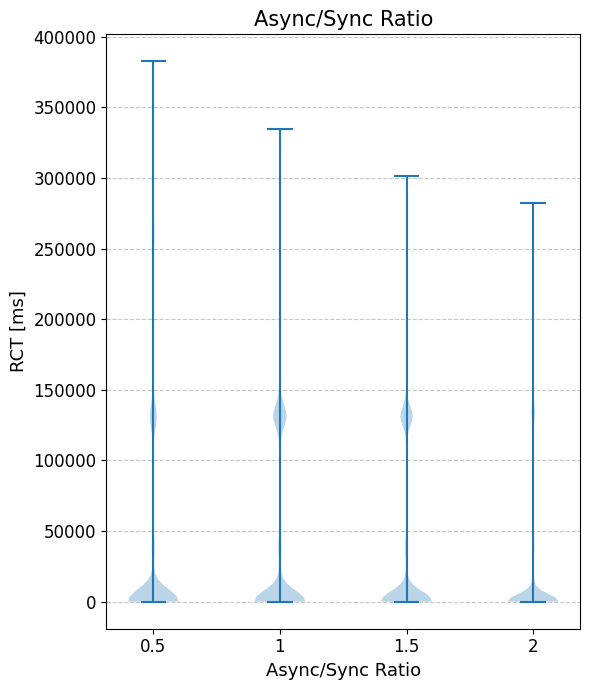

In [36]:
import matplotlib.pyplot as plt

def plot_boxplots(data_arrays, x_labels, y_label="Time (ms)", title="Box Plot of Data"):
    """
    Plot multiple box plots for given data arrays.

    Parameters:
    - data_arrays (list of lists/arrays): A list containing 4 arrays of data to plot.
    - x_labels (list): A list of x-axis labels corresponding to the box plots.
    - y_label (str): Label for the y-axis.
    - title (str): Title of the plot.
    """
    if len(data_arrays) != len(x_labels):
        raise ValueError("Number of data arrays must match the number of x-axis labels")

    plt.figure(figsize=(6, 7))  # Set the figure size

    # Create the boxplot
    plt.violinplot(data_arrays, positions=x_labels, widths=0.2)

    # Add labels and title
    plt.xlabel("Async/Sync Ratio", fontsize=13)
    plt.ylabel(y_label, fontsize=13)
    plt.title(title, fontsize=15)

    # Customize the x-axis ticks
    plt.xticks(ticks=x_labels, labels=x_labels, fontsize=12)
    plt.yticks(fontsize=12)
    plt.yscale("linear")

    # Add grid for better readability
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
with open('./results/async_ratio_results/as_dmix1_0.5_rct.json', 'r') as f:
    data1 = json.load(f)
with open('./results/async_ratio_results/as_dmix1_1_rct.json', 'r') as f:
    data2 = json.load(f)
with open('./results/async_ratio_results/as_dmix1_1.5_rct.json', 'r') as f:
    data3 = json.load(f)
with open('./results/async_ratio_results/as_dmix1_2_rct.json', 'r') as f:
    data4 = json.load(f)

print(max(data4))
# data1 = [10, 12, 15, 11, 14, 13]
# data2 = [20, 22, 19, 18, 21]
# data3 = [30, 35, 32, 28, 29, 31]
# data4 = [40, 42, 41, 39, 38, 43]

x_labels = [0.5, 1, 1.5, 2]  # X-axis values
data_arrays = [data1, data2, data3, data4]

# Call the function to plot
plot_boxplots(data_arrays, x_labels, y_label="RCT [ms]", title="Async/Sync Ratio")


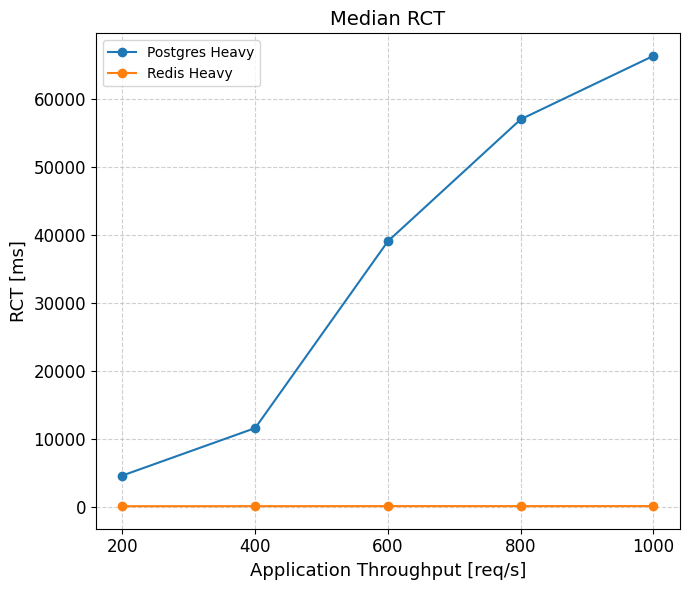

In [ ]:
import matplotlib.pyplot as plt

def plot_throughput(data):

    plt.figure(figsize=(7, 6))  # Set figure size

    for label, values in data.items():
        # Sort the keys (throughput) to ensure the line is plotted in order
        x = sorted(values.keys(), key=lambda k: int(k))  # Convert keys to integers for sorting
        y = [values[k] for k in x]
        
        # Plot the line with markers
        plt.plot(x, y, marker='o', label=label)

    # Add labels and title
    plt.xlabel('Application Throughput [req/s]', fontsize=13)
    plt.xticks(fontsize=12)
    plt.ylabel('RCT [ms]', fontsize=13)
    plt.yticks(fontsize=12)
    plt.title('Median RCT', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid lines
    plt.tight_layout()  # Adjust layout to prevent clipping

    # Show the plot
    plt.show()

# Call the function to plot
plot_throughput(exp_output)


### Async/Sync Ratio Experiment

In [57]:
# as_rct_res = read_rct_data("./results/pg_heavy_results", "as", as_exp_filter)
def read_rct_data_as_exp(dir_name):
    rct_results = {}
    for file in os.listdir(dir_name):
        if file.endswith('.json'):
            res = []
            parts = file.rsplit('_', 2)  # Split at last underscore
            if len(parts) > 1:
                extracted_number = parts[-2]  # Last element is the number
                with open(os.path.join(dir_name, file), 'r') as f:
                    res = json.load(f)
                rct_results[extracted_number] = res
    return rct_results

def as_exp(as_rct_res, focus='median'):
    # Calculate the median RT for each bin
    rt_stats = {}
    for as_val, rct_res in as_rct_res.items():
        if focus == 'median':
            rt_stats[as_val] = np.median(rct_res)
        elif focus == 'mean':
            rt_stats[as_val] = np.mean(rct)
        elif focus == 'p90':
            rt_stats[as_val] = np.percentile(rct_res, 90)
        elif focus == 'p99':
            rt_stats[as_val] = np.percentile(rct_res, 99)
    return rt_stats

as_rct_res = read_rct_data_as_exp("./results/async_ratio_results")
as_rt_stats = as_exp(as_rct_res, focus='p90')
as_rt_stats


{'1.5': np.float64(572.7850000000047),
 '1': np.float64(622.81),
 '0.5': np.float64(557.0056000000018)}

### Frequency Distribution of Rct

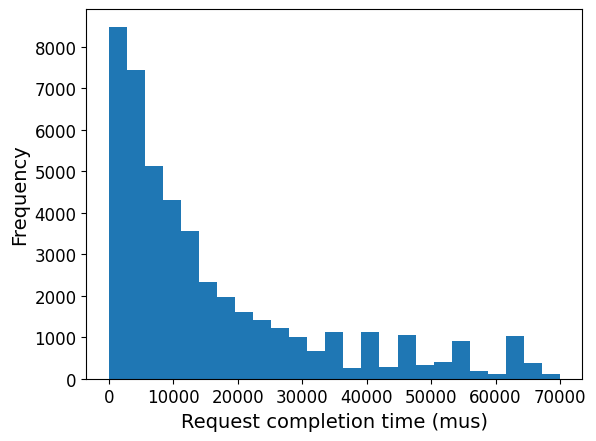

In [26]:
'''Frequency distribution of request completion time for each rct bin by one second bins from rct_results'''
with open('./results/pg_heavy_results/pgh_thr500_rct.json', 'r') as file:
    rct_data = json.load(file)
results=[]
for i in rct_data:
    i = i * 1000
    if i > 0 and i < 70000:
        results.append(i)
plt.hist(results, bins=25)

plt.xlabel('Request completion time (mus)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# xticks font size


In [ ]:
# print(rct_results)
counts, bin_edges = np.histogram(rct_results, bins=10)

# Create bin centers for the line plot
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create the line plot
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, counts, marker='o', linestyle='-', color='blue')

# Add titles and labels
plt.title("Distribution of RCT")
plt.xlabel("Rct")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [ ]:
# # with open("rt_stats.yml", "r") as file:
# #     data = yaml.safe_load(file)
# # print(data.keys())
# # import numpy as np
# # import yaml

# # Load the YAML data from a file
# def load_yaml_file(file_path):
#     with open(file_path, 'r') as file:
#         data = yaml.safe_load(file)
#     return data['processing_times_sl_hist']  # Access the nested key

# def calculate_percentiles_from_hist(hist):
#     # Create the data array using numpy.repeat
#     values = [item['rt'] for item in hist if 'rt' in item]
#     weights = [item['count'] for item in hist if 'count' in item]
    
#     # Use numpy's repeat function to handle large counts efficiently
#     data = np.repeat(values, weights)
    
#     # Calculate percentiles from 1st to 100th
#     percentiles = np.percentile(data, np.arange(1, 101))
    
#     # Round the percentiles to 3 decimal places
#     percentiles = np.round(percentiles, 2)
    
#     return percentiles
# # 
# # Example of how to use the function
# yaml_data = load_yaml_file("rt_stats.yml")
# percentiles = calculate_percentiles_from_hist(yaml_data)
# print([int(p) for p in percentiles])


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 8, 8, 9, 9, 10, 11, 11, 12, 13, 15, 16, 18, 20, 22, 25, 29, 33, 39, 45, 52, 62, 70, 78, 87, 97, 111, 126, 143, 164, 188, 220, 254, 289, 331, 379, 446, 3892811]


In [ ]:

# with open("rt_stats.yml", 'r') as file:
#     data = yaml.safe_load(file)
# # Extract the counts and response times (rt)
# counts = [item['count'] for item in data['processing_times_sl_hist']]
# rts = [item['rt'] for item in data['processing_times_sl_hist']]

# # Create a bar chart
# plt.bar(rts, counts)

# # Labeling the chart
# plt.xlabel('Response Time (rt)')
# plt.ylabel('Count')
# plt.title('Frequency Distribution of Response Times')

# # Display the graph
# plt.show()